In [3]:
import pandas as pd
import glob
import os
import json
from collections import Counter
from matplotlib import pyplot as plt
import seaborn as sns

In [4]:
agab_df = pd.read_parquet('agab.parquet')

print(f"Всего записей: {len(agab_df)}")

Всего записей: 337196


In [5]:
agab_df.head()

,dataset,heavy_sequence,light_sequence,scfv,affinity_type,affinity,antigen_sequence,confidence,nanobody,metadata,processed_measurement,heavy_species,light_species,heavy_germlines,light_germlines,heavy_numbering,light_numbering
0,abdesign,QVQLVQSGAEVKKPGASVKVSCKASGYTFTSYWINWVRQAPGQGLE...,DIVMTQSPDSLAVSLGERATINCKSSQSLWDSGNQKNFLTWYQQKP...,False,elisa_mut_to_wt_ratio,1.008535785,WNPPTFSPALLVVTEGDNATFTCSFSNTSESFVLNWYRMSPSNQTD...,very_high,False,{'heavy_riot_numbering': {'cdr1_aa': 'GYTFTSYW...,1.008535785,mouse,human,"{'v_gene': [('human', 'IGHV1-46*01'), 0.857142...","{'v_gene': [('human', 'IGKV4-1*01'), 0.8877551...","[{""domain_start"": 0, ""domain_end"": 116, ""resid...","[{""domain_start"": 0, ""domain_end"": 112, ""resid..."
1,abdesign,VQLVQSGVEVKKPGASVKVSCKASGYTFTNYYMYWVRQAPGQGLEW...,EIVLTQSPATLSLSPGERATLSCRASKGVSTSGYSYLHWYQQKPGQ...,False,elisa_mut_to_wt_ratio,1.052205794,PWNPPTFSPALLVVTEGDNATFTCSFSNTSESFVLNWYRMSPSNQT...,very_high,False,{'heavy_riot_numbering': {'cdr1_aa': 'GYTFTNYY...,1.052205794,mouse,human,"{'v_gene': [('human', 'IGHV1-2*02'), 0.7857142...","{'v_gene': [('human', 'IGKV3-11*01'), 0.858695...","[{""domain_start"": 0, ""domain_end"": 118, ""resid...","[{""domain_start"": 0, ""domain_end"": 110, ""resid..."
2,structures-antibodies,QVQLQQPGAELVKPGASVKLSCKASGYTFTSDWIHWVKQRPGHGLE...,DILLTQSPAILSVSPGERVSFSCRASQSIGTDIHWYQQRTNGSPRL...,False,bool,1.0,SALHWRAAGAATVLLVIVLLAGSYLAVLAERGAPGAQLITYPRALW...,very_high,False,{'heavy_riot_numbering': {'cdr1_aa': 'GYTFTSDW...,1.0,mouse,mouse,"{'v_gene': [('mouse', 'IGHV1-69-5*01'), 0.8877...","{'v_gene': [('mouse', 'IGKV5-48*01'), 0.978260...","[{""domain_start"": 0, ""domain_end"": 117, ""resid...","[{""domain_start"": 0, ""domain_end"": 106, ""resid..."
3,structures-antibodies,EVQLVESGGGLVQPGGSLRLSCAASGFTFDDYSMNWVRQAPGKGLE...,DIQLTQSPSSLSASVGDRVTITCQASQDISNYLNWYQQKPGKAPKL...,False,bool,1.0,FKVATPYSLYVCPEGQNVTLTCRLLGPVDKGHDVTFYKTWYRSSRG...,very_high,False,{'heavy_riot_numbering': {'cdr1_aa': 'GFTFDDYS...,1.0,human,human,"{'v_gene': [('human', 'IGHV3-48*01'), 0.948979...","{'v_gene': [('human', 'IGKV1-33*01'), 0.967391...","[{""domain_start"": 0, ""domain_end"": 121, ""resid...","[{""domain_start"": 0, ""domain_end"": 107, ""resid..."
4,structures-antibodies,VKLQESGAVVQPGGSLRLSCAASGFTGSDYDMSWIRQAPGKGLEWV...,DIQMTQSPASLAVSPGQRATITCRASESVSNYGINFINWFQQKPGQ...,False,bool,1.0,ADPGYLLEFDTLCIGYHANNSTDTVDTVLEKNVTVTHSVNLLEDKH...,very_high,False,{'heavy_riot_numbering': {'cdr1_aa': 'GFTGSDYD...,1.0,human,mouse,"{'v_gene': [('human', 'IGHV3-66*01'), 0.773195...","{'v_gene': [('mouse', 'IGKV3-2*01'), 0.8020833...","[{""domain_start"": 0, ""domain_end"": 119, ""resid...","[{""domain_start"": 0, ""domain_end"": 110, ""resid..."


In [7]:
print("=== ПРОВЕРКА РЕЗУЛЬТАТОВ ОБРАБОТКИ (agab_df_test) ===\n")

# 1. Проверка наличия новых колонок
expected_cols = [
    'heavy_species', 'light_species',
    'heavy_germlines', 'light_germlines',
    'heavy_numbering', 'light_numbering'
]
missing_cols = [c for c in expected_cols if c not in agab_df.columns]
if missing_cols:
    print(f"[ОШИБКА] Отсутствуют колонки: {missing_cols}")
else:
    print(f"[OK] Все новые колонки созданы: {expected_cols}")

# 2. Проверка заполнения (непустые значения)
print("\n--- Статистика заполнения ---")
total_rows = len(agab_df)
if total_rows > 0:
    for col in expected_cols + ['heavy_sequence', 'light_sequence']:
        filled = agab_df[col].notna().sum()
        print(f"{col}: {filled}/{total_rows} ({filled/total_rows*100:.1f}%)")
else:
    print("Датафрейм пуст!")

# 3. Проверка формата JSON в numbering
print("\n--- Проверка формата JSON (первые 3 непустых) ---")
sample_h = agab_df[agab_df['heavy_numbering'].notna()].head(3)
for idx, row in sample_h.iterrows():
    try:
        data = json.loads(row['heavy_numbering'])
        print(f"[OK] Row {idx} heavy_numbering valid JSON. Domains: {len(data)}")
        if data:
             print(f"     First domain residues count: {len(data[0].get('residues', []))}")
    except Exception as e:
        print(f"[ОШИБКА] Row {idx} heavy_numbering invalid JSON: {e}")

# 4. Проверка разделения scFv
print("\n--- Проверка разделения scFv ---")
scfv_rows = agab_df[agab_df['scfv'] == True]
if len(scfv_rows) > 0:
    scfv_with_chains = scfv_rows[
        scfv_rows['heavy_sequence'].notna() & 
        scfv_rows['light_sequence'].notna()
    ]
    scfv_only_heavy = scfv_rows[
        scfv_rows['heavy_sequence'].notna() & 
        scfv_rows['light_sequence'].isna()
    ]
    scfv_only_light = scfv_rows[
        scfv_rows['heavy_sequence'].isna() & 
        scfv_rows['light_sequence'].notna()
    ]
    print(f"Всего scFv: {len(scfv_rows)}")
    print(f"scFv с обеими цепями (H+L): {len(scfv_with_chains)} ({len(scfv_with_chains)/len(scfv_rows)*100:.1f}%)")
    print(f"scFv только с Heavy: {len(scfv_only_heavy)} ({len(scfv_only_heavy)/len(scfv_rows)*100:.1f}%)")
    print(f"scFv только с Light: {len(scfv_only_light)} ({len(scfv_only_light)/len(scfv_rows)*100:.1f}%)")
else:
    print("В датафрейме нет записей scFv.")

# 5. Пример данных
print("\n--- Пример одной записи (Heavy) ---")
if not sample_h.empty:
    example_row = sample_h.iloc[0]
    print(f"Species: {example_row['heavy_species']}")
    print(f"Germlines: {example_row['heavy_germlines']}")
    print(f"Sequence (trimmed): {example_row['heavy_sequence'][:20]}...")
else:
    print("Нет обработанных heavy chains для показа примера.")


=== ПРОВЕРКА РЕЗУЛЬТАТОВ ОБРАБОТКИ (agab_df_test) ===

[OK] Все новые колонки созданы: ['heavy_species', 'light_species', 'heavy_germlines', 'light_germlines', 'heavy_numbering', 'light_numbering']

--- Статистика заполнения ---
heavy_species: 337196/337196 (100.0%)
light_species: 337196/337196 (100.0%)
heavy_germlines: 337196/337196 (100.0%)
light_germlines: 337196/337196 (100.0%)
heavy_numbering: 337196/337196 (100.0%)
light_numbering: 337196/337196 (100.0%)
heavy_sequence: 337196/337196 (100.0%)
light_sequence: 337196/337196 (100.0%)

--- Проверка формата JSON (первые 3 непустых) ---
[OK] Row 0 heavy_numbering valid JSON. Domains: 1
     First domain residues count: 128
[OK] Row 1 heavy_numbering valid JSON. Domains: 1
     First domain residues count: 128
[OK] Row 2 heavy_numbering valid JSON. Domains: 1
     First domain residues count: 128

--- Проверка разделения scFv ---
Всего scFv: 53603
scFv с обеими цепями (H+L): 53603 (100.0%)
scFv только с Heavy: 0 (0.0%)
scFv только с Lig

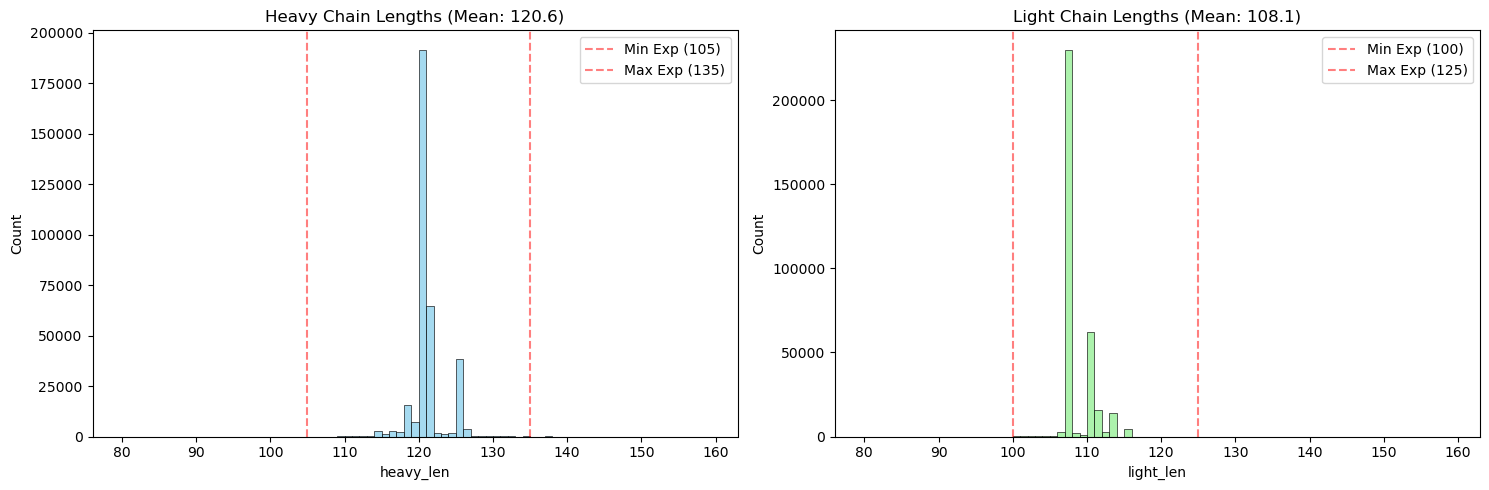


=== Выбросы по длине ===
Heavy < 90 aa: 25 шт.
Heavy > 140 aa: 10 шт.
Light < 90 aa: 126 шт.
Light > 135 aa: 0 шт.

=== Топ-10 паттернов начала и конца (Heavy) ===
Start: [('EVQLV', 202025), ('QVQLV', 119253), ('QVQLQ', 6634), ('EVQLL', 1413), ('EVQLQ', 1175), ('QVQLK', 590), ('QVTLK', 499), ('EVKLV', 348), ('QIQLV', 334), ('VQLVQ', 184)]
End:   [('VTVSS', 328415), ('LTVSS', 2663), ('TTLTV', 2046), ('LVTVS', 772), ('VTVSA', 721), ('TLVTV', 282), ('VIVSS', 270), ('WGQGT', 143), ('YWGQG', 121), ('SVTVS', 94)]

=== Топ-10 паттернов начала и конца (Light) ===
Start: [('DIQMT', 183080), ('QSALT', 60719), ('DVQMT', 41563), ('EIVLT', 14490), ('DVVMT', 14175), ('QAVLT', 4374), ('DIELT', 3244), ('DIVMT', 2969), ('QSVLT', 2854), ('DIVLT', 1174)]
End:   [('KVEIK', 250481), ('QLTVL', 60368), ('KLEIK', 10338), ('KLTVL', 8586), ('KLELK', 1318), ('KVDIK', 773), ('KVTVL', 658), ('RLEIK', 628), ('TKVEI', 294), ('TKLEI', 247)]

=== Проверка консервативных цистеинов (C23, C104) ===
Heavy Chains with bot

In [ ]:
# Функция для безопасного извлечения длины
def get_len(seq):
    return len(seq) if isinstance(seq, str) else 0

df['heavy_len'] = df['heavy_sequence'].apply(get_len)
df['light_len'] = df['light_sequence'].apply(get_len)

# --- ПРОВЕРКА 1: Распределение длин ---
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Heavy chain length
h_lens = df[df['heavy_len'] > 0]['heavy_len']
sns.histplot(h_lens, bins=range(80, 160), ax=axes[0], color='skyblue')
axes[0].set_title(f'Heavy Chain Lengths (Mean: {h_lens.mean():.1f})')
axes[0].axvline(105, color='r', linestyle='--', alpha=0.5, label='Min Exp (105)')
axes[0].axvline(135, color='r', linestyle='--', alpha=0.5, label='Max Exp (135)')
axes[0].legend()

# Light chain length
l_lens = df[df['light_len'] > 0]['light_len']
sns.histplot(l_lens, bins=range(80, 160), ax=axes[1], color='lightgreen')
axes[1].set_title(f'Light Chain Lengths (Mean: {l_lens.mean():.1f})')
axes[1].axvline(100, color='r', linestyle='--', alpha=0.5, label='Min Exp (100)')
axes[1].axvline(125, color='r', linestyle='--', alpha=0.5, label='Max Exp (125)')
axes[1].legend()

plt.tight_layout()
plt.show()

# Выбросы
print("\n=== Выбросы по длине ===")
print(f"Heavy < 90 aa: {len(h_lens[h_lens < 90])} шт.")
print(f"Heavy > 140 aa: {len(h_lens[h_lens > 140])} шт.")
print(f"Light < 90 aa: {len(l_lens[l_lens < 90])} шт.")
print(f"Light > 135 aa: {len(l_lens[l_lens > 135])} шт.")

# --- ПРОВЕРКА 2: Start/End паттерны ---
def get_top_kmers(sequences, k=5, n=10, side='start'):
    seqs = [s for s in sequences if isinstance(s, str) and len(s) >= k]
    if side == 'start':
        kmers = [s[:k] for s in seqs]
    else:
        kmers = [s[-k:] for s in seqs]
    return Counter(kmers).most_common(n)

print("\n=== Топ-10 паттернов начала и конца (Heavy) ===")
print("Start:", get_top_kmers(df['heavy_sequence'], side='start'))
print("End:  ", get_top_kmers(df['heavy_sequence'], side='end'))

print("\n=== Топ-10 паттернов начала и конца (Light) ===")
print("Start:", get_top_kmers(df['light_sequence'], side='start'))
print("End:  ", get_top_kmers(df['light_sequence'], side='end'))

# --- ПРОВЕРКА 3: Консервативные цистеины (из numbering) ---
print("\n=== Проверка консервативных цистеинов (C23, C104) ===")

def check_cysteines(numbering_json):
    if not numbering_json or pd.isna(numbering_json):
        return None
    try:
        data = json.loads(numbering_json)
        if not data: return False
        
        # Получаем список остатков первого домена
        residues = data[0].get('residues', [])
        
        has_c23 = False
        has_c104 = False
        
        for r in residues:
            # r['pos'] это номер позиции IMGT
            # r['aa'] это аминокислота
            pos = r.get('pos')
            aa = r.get('aa')
            
            if pos == 23 and aa == 'C':
                has_c23 = True
            if pos == 104 and aa == 'C':
                has_c104 = True
                
        return has_c23 and has_c104
    except:
        return None

df['heavy_cys_ok'] = df['heavy_numbering'].apply(check_cysteines)
df['light_cys_ok'] = df['light_numbering'].apply(check_cysteines)

print(f"Heavy Chains with both C23 & C104: {df['heavy_cys_ok'].sum()} / {df['heavy_numbering'].notna().sum()}")
print(f"Light Chains with both C23 & C104: {df['light_cys_ok'].sum()} / {df['light_numbering'].notna().sum()}")

# --- ПРОВЕРКА 4: Зависимость от вида (Species) ---
print("\n=== Средняя длина по видам===")
top_species = df['heavy_species'].value_counts().index
print(df[df['heavy_species'].isin(top_species)].groupby('heavy_species')['heavy_len'].agg(['mean', 'std', 'count']))

In [11]:

print("=== DEEP DIVE INTO OUTLIERS ===\n")

def analyze_domain_quality(numbering_json, sequence):
    """
    Analyzes domain quality based on ANARCI numbering and sequence content.
    Returns a dict with quality metrics.
    """
    if not numbering_json or pd.isna(numbering_json):
        return {
            'has_hit': False,
            'imgt_coverage': 0,
            'has_c23_c104': False,
            'x_content': 0,
            'stop_codons': 0
        }
    
    try:
        data = json.loads(numbering_json)
        if not data:
             return {
                'has_hit': False, 
                'imgt_coverage': 0,
                'has_c23_c104': False,
                'x_content': 0,
                'stop_codons': 0
            }
        
        # Taking the first domain found
        residues = data[0].get('residues', [])
        
        # Calculate IMGT coverage (number of positions filled)
        imgt_coverage = len(residues)
        
        # Check Cysteines
        has_c23 = False
        has_c104 = False
        for r in residues:
            if r['pos'] == 23 and r['aa'] == 'C': has_c23 = True
            if r['pos'] == 104 and r['aa'] == 'C': has_c104 = True
            
        # Sequence content checks
        if isinstance(sequence, str):
            x_count = sequence.count('X')
            stop_count = sequence.count('*')
            seq_len = len(sequence)
            x_ratio = x_count / seq_len if seq_len > 0 else 0
        else:
            x_ratio = 0
            stop_count = 0
            
        return {
            'has_hit': True,
            'imgt_coverage': imgt_coverage,
            'has_c23_c104': has_c23 and has_c104,
            'x_content': x_ratio,
            'stop_codons': stop_count
        }
    except Exception as e:
        print(f"Error parsing JSON: {e}")
        return {
            'has_hit': False,
            'imgt_coverage': 0, 
            'has_c23_c104': False,
            'x_content': 0,
            'stop_codons': 0
        }

# Ensure helper columns exist if running this cell independently
if 'heavy_cys_ok' not in agab_df.columns:
    print("Recalculating cysteine checks...")
    def check_cysteines(numbering_json):
        if not numbering_json or pd.isna(numbering_json): return None
        try:
            data = json.loads(numbering_json)
            if not data: return False
            residues = data[0].get('residues', [])
            has_c23 = any(r['pos'] == 23 and r['aa'] == 'C' for r in residues)
            has_c104 = any(r['pos'] == 104 and r['aa'] == 'C' for r in residues)
            return has_c23 and has_c104
        except: return None
    
    agab_df['heavy_cys_ok'] = agab_df['heavy_numbering'].apply(check_cysteines)
    agab_df['light_cys_ok'] = agab_df['light_numbering'].apply(check_cysteines)

# Define outlier groups by sequence length (count directly)
outliers_h_short = agab_df[agab_df['heavy_sequence'].apply(lambda x: len(x) if isinstance(x, str) else 0) < 90].copy()
outliers_h_long = agab_df[agab_df['heavy_sequence'].apply(lambda x: len(x) if isinstance(x, str) else 0) > 140].copy()
outliers_l_short = agab_df[agab_df['light_sequence'].apply(lambda x: len(x) if isinstance(x, str) else 0) < 90].copy()

groups = {
    'Heavy < 90': (outliers_h_short, 'heavy'),
    'Heavy > 140': (outliers_h_long, 'heavy'),
    'Light < 90': (outliers_l_short, 'light')
}

for name, (group_agab_df, chain_type) in groups.items():
    if len(group_agab_df) == 0:
        print(f"\n--- {name}: No outliers found ---")
        continue
        
    print(f"\n--- Analysis of {name} ({len(group_agab_df)} items) ---")
    
    # Calculate quality metrics for this group
    metrics = []
    for idx, row in group_agab_df.iterrows():
        seq_col = f'{chain_type}_sequence'
        num_col = f'{chain_type}_numbering'
        m = analyze_domain_quality(row[num_col], row[seq_col])
        m['index'] = idx
        metrics.append(m)
        
    metrics_agab_df = pd.DataFrame(metrics)
    
    # Summary stats
    print(f"Has confident ANARCI hit: {metrics_agab_df['has_hit'].sum()}/{len(group_agab_df)}")
    print(f"Has both C23 & C104: {metrics_agab_df['has_c23_c104'].sum()}/{len(group_agab_df)}")
    print(f"Avg IMGT coverage: {metrics_agab_df['imgt_coverage'].mean():.1f} positions")
    print(f"Avg 'X' content: {metrics_agab_df['x_content'].mean()*100:.2f}%")
    print(f"Contains Stop (*): {metrics_agab_df['stop_codons'].astype(bool).sum()}")
    
    # Show examples
    print(f"\nExamples ({min(3, len(group_agab_df))}):")
    for i, idx in enumerate(group_agab_df.index[:3]):
        row = group_agab_df.loc[idx]
        seq = row[f'{chain_type}_sequence']
        print(f"{i+1}. ID: {idx}, Len: {len(seq)}")
        print(f"   Seq: {seq}")
        print(f"   Species: {row[f'{chain_type}_species']}")
        # Show germline info if available
        # print(f"   Germline: {row[f'{chain_type}_germlines']}")

# --- IMPLEMENTING FLAGS ---
print("\n=== APPLYING QUALITY FLAGS TO FULL DATASET ===")

def check_row_quality(row):
    # Check Heavy
    h_qual = analyze_domain_quality(row['heavy_numbering'], row['heavy_sequence'])
    h_ok = h_qual['has_hit'] and h_qual['has_c23_c104'] and h_qual['imgt_coverage'] > 70 # Arbitrary threshold for "too short" coverage
    
    # Check Light
    l_qual = analyze_domain_quality(row['light_numbering'], row['light_sequence'])
    l_ok = l_qual['has_hit'] and l_qual['has_c23_c104'] and l_qual['imgt_coverage'] > 70
    
    return h_ok, l_ok

# Apply to a sample first to test speed, or full agab_df if reasonable
# Using apply with a wrapper or vectorized approach is better
# For speed, we'll use the pre-calculated columns if possible, but we need to parse JSON.
# Since we already have 'heavy_cys_ok' and 'light_cys_ok' from previous cell, let's use them.

# Let's add coverage check
def get_coverage(numbering_json):
    if not numbering_json or pd.isna(numbering_json): return 0
    try:
        data = json.loads(numbering_json)
        return len(data[0]['residues']) if data else 0
    except: return 0

agab_df['heavy_imgt_cov'] = agab_df['heavy_numbering'].apply(get_coverage)
agab_df['light_imgt_cov'] = agab_df['light_numbering'].apply(get_coverage)

# Flagging logic
# 1. Structural integrity (Must have C23 & C104) -> We already have *_cys_ok
# 2. Minimum information (Must have decent IMGT coverage, e.g. > 80 positions)
# 3. No bad symbols (Check for *)

# Let's create 'quality_flag'
# True = Good, False = Bad/Questionable

# Criteria for "Good":
# - Both Cysteines present
# - IMGT coverage > 80 (Standard V-domain is ~110-120, <80 is very partial)
# - Length within reasonable bounds (flagging, not strict cut) OR coverage is excellent
#   Actually, if Cys ok and Coverage ok, length is secondary (long CDRH3 is fine)

agab_df['heavy_valid'] = agab_df['heavy_cys_ok'] & (agab_df['heavy_imgt_cov'] > 80)
agab_df['light_valid'] = agab_df['light_cys_ok'] & (agab_df['light_imgt_cov'] > 80)

print("Filtering Statistics:")
print(f"Valid Heavy Chains: {agab_df['heavy_valid'].sum()} / {len(agab_df)} ({agab_df['heavy_valid'].mean()*100:.1f}%)")
print(f"Valid Light Chains: {agab_df['light_valid'].sum()} / {len(agab_df)} ({agab_df['light_valid'].mean()*100:.1f}%)")

# Intersection (Both valid)
agab_df['full_ab_valid'] = agab_df['heavy_valid'] & agab_df['light_valid']
print(f"Both Chains Valid: {agab_df['full_ab_valid'].sum()} / {len(agab_df)} ({agab_df['full_ab_valid'].mean()*100:.1f}%)")

# Look at what we are dropping
dropped = agab_df[~agab_df['full_ab_valid']]
print(f"\nDropped {len(dropped)} sequences. Reasons:")

if len(dropped) > 0:
    print("Bad Heavy Cys:", (~dropped['heavy_cys_ok']).sum())
    print("Bad Light Cys:", (~dropped['light_cys_ok']).sum())
    print("Low Heavy Coverage (<80):", (dropped['heavy_imgt_cov'] <= 80).sum())
    print("Low Light Coverage (<80):", (dropped['light_imgt_cov'] <= 80).sum())

# Check overlap with length outliers
print("\nOverlap with Length Outliers:")
h_short_valid = agab_df.loc[outliers_h_short.index, 'heavy_valid'].sum()
print(f"Heavy < 90 deemed valid: {h_short_valid} / {len(outliers_h_short)}")

h_long_valid = agab_df.loc[outliers_h_long.index, 'heavy_valid'].sum()
print(f"Heavy > 140 deemed valid: {h_long_valid} / {len(outliers_h_long)}")

l_short_valid = agab_df.loc[outliers_l_short.index, 'light_valid'].sum()
print(f"Light < 90 deemed valid: {l_short_valid} / {len(outliers_l_short)}")


=== DEEP DIVE INTO OUTLIERS ===


--- Analysis of Heavy < 90 (25 items) ---
Has confident ANARCI hit: 25/25
Has both C23 & C104: 13/25
Avg IMGT coverage: 117.0 positions
Avg 'X' content: 0.00%
Contains Stop (*): 0

Examples (3):
1. ID: 15410, Len: 84
   Seq: VQLVESGGGLVQPGGSLRLSCAASGFTFSDYYMTWVRQAPGKGLEWVAFIRNRARGYTSDHNPSVKGRFTISRDNAKNSLYLQM
   Species: human
2. ID: 32629, Len: 65
   Seq: QVQLQQSGPELVKPGASVRISCKASGYTFTNYYMHWVKQRPGQGLEWIGWIYPGNVNTYYNEKFR
   Species: mouse
3. ID: 32638, Len: 84
   Seq: LSLVCKASGFTFSSNAMGWVRQAPGKGLEWVAGIDDDGSGTRYAPAVKGRATISRDNGQSTLRLQLNNLRAEDTGIYYCTKCAY
   Species: human

--- Analysis of Heavy > 140 (10 items) ---
Has confident ANARCI hit: 10/10
Has both C23 & C104: 10/10
Avg IMGT coverage: 177.0 positions
Avg 'X' content: 0.00%
Contains Stop (*): 0

Examples (3):
1. ID: 82251, Len: 168
   Seq: QVQLRESGPSLMKPSQTLSLTCTVSGSSLNDKSVGWVRQAPGKALQWLGSVDTSGNTDYNPGLKSRLSITKDNSKSRISLTVTGMTTEDSATYYCITAHQKTNKKECPEDYTYNPRCPQQYGWSDCDCMGDRFGGYCRQDGCSNYIHRSTYEWYVSAWGQGLL